## Deep Learning Project:

A study on reinforcement learning for the game of Super Mario Bros and Zelda on the NES.

By: Stricescu Razvan Ciprian

### Libraries used:

In [1]:
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os

# Gym is an OpenAI toolkit for RL
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack
from gym import spaces

# NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace

# Super Mario environment for OpenAI Gym
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, RIGHT_ONLY, COMPLEX_MOVEMENT

from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

import numpy as np
import time, datetime
import matplotlib.pyplot as plt
import random

Here I define the environment based on the version of gym as the gym_super_mario_bros library is not compatible with the latest version of gym and requires apy compatibility.

The main difference is in the step function which returns **{next state, reward, done, trunc, info}** instead of **{next state, reward, done, trunc, info}**.

In [2]:
if gym.__version__ < '0.26':
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", new_step_api=True)
else:
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", render_mode = 'human' ,apply_api_compatibility=True)

env_name = env.spec.id # will be used to save files later

d:\Python3.10\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
d:\Python3.10\lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


The reward function assumes the objective of the game is to move as far right as possible (increase the agent's x value), as fast as possible, without dying.

The reward function is defined as follows:
- v: the difference in agent x values between states.
- c: the difference in the game clock between frames.
- d: a death penalty that penalizes the agent for dying in a state.

Thus the reward function is defined as: **v + c + d**


The info returned by the step function is a dictionary containing the following information:

|   coins  |             number of coins             |
|:--------:|:---------------------------------------:|
| flag_get |      whether mario got to the flag      |
|   life   |           number of lifes left          |
|   score  |               total score               |
|   stage  |            level in the world           |
|  status  | mario's status (small, large, fireball) |
|   time   |      time left on the in-game clock     |
|   world  |              current world              |
|   x_pos  |           horizontal position           |
|   y_pos  |            vertical position            |


### Preprocessing:

In order to optimize the training process, the following preprocessing steps were taken as environment wrappers:

- **Skip Frames**: The environment is wrapped in a skip frame wrapper that skips a number of frames and returns the last frame as the state. This is done to reduce the number of frames the agent has to process and to speed up the training process.

- **Gray Scale**: The environment is wrapped in a gray scale wrapper that converts the state to gray scale. This is done to reduce the number of channels the agent has to process and to speed up the training process.

- **Resize**: The environment is wrapped in a resize wrapper that resizes the state to a smaller size. This is done to reduce the number of pixels the agent has to process and to speed up the training process.

In [3]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip
        self._obs_buffer = np.zeros((2,) + env.observation_space.shape, dtype=np.uint8)

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, trunc, info = self.env.step(action)
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, trunc, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape, antialias=True), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

class EpisodicLifeMario(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action):
        obs, reward, done, trunc, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = info["life"]
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return  obs, reward, done, trunc, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _, info= self.env.step(0)
            self.lives = info["life"]
        return obs


class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        # assert env.unwrapped.get_action_meanings()[0] == "NOOP"

    def reset(self, **kwargs):
        """Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = random.randint(
                1, self.noop_max + 1
            )  # pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ , _= self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)


Now we apply the wrappers to the environment and also define the movement space (the actions the agent can take):

In [4]:
# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
# env = NoopResetEnv(env, noop_max=30)
if "SuperMarioBros" in env_name:
    env = EpisodicLifeMario(env)
if gym.__version__ < '0.26':
    env = FrameStack(env, num_stack=4, new_step_api=True) # Version dependent as the step API changed
else:
    env = FrameStack(env, num_stack=4)

# Define movement space
env = JoypadSpace(env, [["right"], ["right", "A"]]) #["NOOP"]
#env = JoypadSpace(env, COMPLEX_MOVEMENT) #["NOOP"]

### Model Architecture and definition:

The CNN architecure is quite small and simple as the agent only needs to learn the basic features of the game, but in order to experiment with different architectures I have defined three different models:

- **Model 1**: A simple CNN with 3 convolutional layers and 2 fully connected layers.
- **Model 2**: Like Model 1, but with Max Pooling layers after each convolutional layer.
- **Model 3**: Like Model 2, but with Batch Normalization layers after each convolutional layer.

Online network: The online network is the network that is used to make predictions and is updated at each step.

Target network: The target network is the network that is used to calculate the target values and is less frequently updated. The idea is to reduce the correlation between the target Q-values and the Q-values predicted by the online network, which can lead to more stable training.

In [5]:
class DQNet(nn.Module):
    """Deep Q-network with target network"""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.online = self.__build_cnn(c, output_dim)

        self.target = self.__build_cnn(c, output_dim)
        self.target.load_state_dict(self.online.state_dict())

        # Q_target parameters are frozen.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

    def __build_cnn(self, c, output_dim):
        return nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
           #nn.BatchNorm2d(32),
           #nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
           #nn.BatchNorm2d(64),
           #nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            #nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
           #nn.BatchNorm2d(64),
           #nn.MaxPool2d(kernel_size=2),
           #nn.ReLU(),
            nn.Flatten(),
            nn.Linear(20736, 3136),
            nn.ReLU(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

### Agent definition:

Exploration is done using an epsilon greedy policy with a linear decay.

The exploration memory is implemented using LazyMemmapStorage from the torrchrl library which is a memory wrapped storage for tensors. The replay buffer is implemented as a TensorDict with the following keys: **state, next_state, action, reward, done**.

For the loss function one close to the Huber loss is used, but with a delta value. The loss function is defined as follows:

**huber(x,y)/beta** (The Huber loss is defined as a piecewise function that behaves like the mean squared error loss for small errors and like the mean absolute error loss for large errors)

It is less sensitive to outliers than the MSE loss and it can also prevent exploding gradient problem.

In [6]:
class Agent:
    def __init__(self, state_dim, action_dim, save_dir):
        self.state_dim = state_dim # state dimension which is (4, 84, 84)
        self.action_dim = action_dim # action dimension which depends on the environment movement space
        self.save_dir = save_dir # directory to save models and plots

        # GPU if available
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Agent's DNN to predict the most optimal action
        self.net = DQNet(self.state_dim, self.action_dim).float()
        self.net = self.net.to(device=self.device)

        # exploration hyperparameters
        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        self.save_every = 5e5  # no. of experiences between saving network weights

        # Experience replay memory
        self.memory = TensorDictReplayBuffer(storage=LazyMemmapStorage(50000, device=torch.device("cpu")))
        self.batch_size = 256 # no. of samples for replay

        # Q-learning hyperparameters
        self.gamma = 0.9  # discount factor for future rewards

        # Optimizer and loss function
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025) # learning rate is really low as we are learning from noisy data
        self.loss_fn = torch.nn.SmoothL1Loss() # reduction by default is mean

        # Training parameters
        self.burnin = 1e4  # min. experiences before training
        self.learn_every = 3  # no. of experiences between updates to Q_online
        self.sync_every = 1e4  # no. of experiences between Q_target & Q_online sync


    def act(self, state):
        """
    Given a state, choose an epsilon-greedy action and update value of step.

    Inputs:
    state(``LazyFrame``): A single observation of the current state, dimension is (state_dim)
    Outputs:
    ``action_idx`` (``int``): An integer representing which action Agent will perform
    """
        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # EXPLOIT
        else:
            state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
            state = torch.tensor(state, device=self.device).unsqueeze(0)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()

        # decrease exploration_rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # increment step
        self.curr_step += 1
        return action_idx


    def cache(self, state, next_state, action, reward, done):
        """
        Store the experience to self.memory (replay buffer)

        Inputs:
        state (``LazyFrame``),
        next_state (``LazyFrame``),
        action (``int``),
        reward (``float``),
        done(``bool``))
        """
        def first_if_tuple(x):
            return x[0] if isinstance(x, tuple) else x
        state = first_if_tuple(state).__array__()
        next_state = first_if_tuple(next_state).__array__()

        state = torch.tensor(state)
        next_state = torch.tensor(next_state)
        action = torch.tensor([action])
        reward = torch.tensor([reward])
        done = torch.tensor([done])

        self.memory.add(TensorDict({"state": state, "next_state": next_state, "action": action, "reward": reward, "done": done}, batch_size=[]))


    def recall(self):
        """
        Retrieve a batch of experiences from memory
        """
        batch = self.memory.sample(self.batch_size).to(self.device)
        state, next_state, action, reward, done = (batch.get(key) for key in ("state", "next_state", "action", "reward", "done"))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()


    def td_estimate(self, state, action):
        """
        Returns Q(s,a) - the model computes Q(s), then we select the columns of the taken actions.
        Inputs:
        state (``LazyFrame``),
        action (``int``)
        Outputs:
        ``Q`` (``torch.tensor``): Q-value of the state-action pair
        """
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q


    @torch.no_grad() # very important, as we do not want to update the target network
    def td_target(self, reward, next_state, done):
        """
        Returns R_t + gamma * max_a(Q_target(s_t+1, a)) predicted by the target network.
        Inputs:
        reward (``torch.tensor``): reward of the state-action pair
        next_state (``LazyFrame``),
        done (``bool``)
        Outputs:
        ``Q`` (``torch.tensor``): Q-value of the state-action pair
        """
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()


    def update_Q_online(self, td_estimate, td_target):
        """
        Updates the weights of Q_online network using the td_estimate and td_target
        """
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        """
        Copies the weights from Q_online to Q_target
        """
        self.net.target.load_state_dict(self.net.online.state_dict())


    def save(self):
        """
        Saves the model at self.save_dir with filename
        {env_name}_net_{curr_step}.chkpt
        """
        save_path = (
            self.save_dir / f"{env_name}_net_{int(self.curr_step // self.save_every)}.chkpt"
        )
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate),
            save_path,
        )
        print(f"{env_name}_net saved to {save_path} at step {self.curr_step}")


    def learn(self):
        """
        Samples a batch from memory and updates Q_online and Q_target
        """
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # Sample from memory
        state, next_state, action, reward, done = self.recall()

        # Get TD Estimate
        td_est = self.td_estimate(state, action)

        # Get TD Target
        td_tgt = self.td_target(reward, next_state, done)

        # Backpropagate loss through Q_online
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)

### Logger class:

The logger class is used to log the training process and to save the model and the plots.

In [7]:
class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        # Update metrics of current episode
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        "Reset episode metrics"
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        # Save metrics from current episode to history
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        # Save metrics
        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        # Plot metrics
        for metric in ["ep_lengths", "ep_avg_losses", "ep_avg_qs", "ep_rewards"]:
            plt.clf()
            plt.plot(getattr(self, f"moving_avg_{metric}"), label=f"moving_avg_{metric}")
            plt.legend()
            plt.savefig(getattr(self, f"{metric}_plot"))

## Training:

The training process is done in episodes, with each one being composed by a number of steps. At each step the agent takes an action, the environment returns the next state, the reward, whether the episode is done and some info about the environment then the agent then stores the transition in the replay buffer and samples a batch of transitions from it to learn from and update the loss function.

The agent then logs the training process and saves the model and the plots.

Using CUDA: True



d:\Python3.10\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Impossibile cambiare la modalità del thread dopo averla impostata
  warnings.warn(str(err))
d:\Python3.10\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


SuperMarioBros-1-1-v0_net saved to checkpoints\2024-01-10T18-25-05\SuperMarioBros-1-1-v0_net_0.chkpt at step 40
Episode 0 - Step 40 - Epsilon 0.9999900000487484 - Mean Reward 231.0 - Mean Length 40.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 4.295 - Time 2024-01-10T18:25:10
Episode 20 - Step 5210 - Epsilon 0.9986983477221798 - Mean Reward 641.667 - Mean Length 248.095 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 93.387 - Time 2024-01-10T18:26:43


KeyboardInterrupt: 

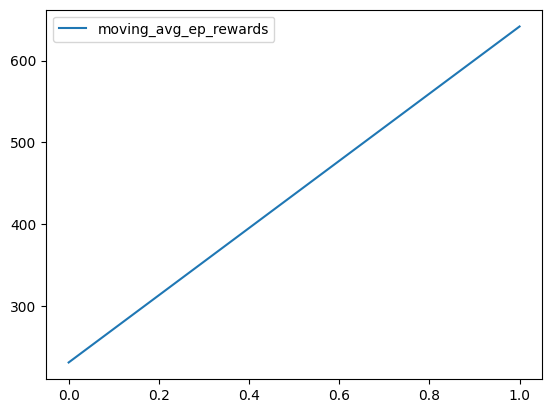

In [8]:
# GPU if available
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

# Creating directories to save models and log files
save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

# Create agent and logger
agent = Agent(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir)
logger = MetricLogger(save_dir)

# Main training loop
episodes = 100
for e in range(episodes):
    state = env.reset()

    # Main training loop for single episode
    while True:

        # Run agent on the state
        action = agent.act(state)

        # Agent performs action
        next_state, reward, done, trunc, info = env.step(action)

        # Remember
        agent.cache(state, next_state, action, reward, done)

        # Learn
        q, loss = agent.learn()

        # Logging
        logger.log_step(reward, loss, q)

        # Update state
        state = next_state

        # Check if end of game
        if done or info["flag_get"]:
            break

    logger.log_episode()

    if e % 100 == 0:
        agent.save()

    if (e % 20 == 0) or (e == episodes - 1):
        logger.record(episode=e, epsilon=agent.exploration_rate, step=agent.curr_step)
